# Monthly Average Time Series (Seasonal Cycle) - IPCC Subregions

In [1]:
# Import modules
%run /g/data/w40/ri9247/code/aus_precip_benchmarking/master_functions_bmf.ipynb
import matplotlib as mpl
import os
import fnmatch
import xarray as xr
import numpy as np
import datetime as dt
import matplotlib.pyplot as plt
import pandas as pd
import plotly.express as px
import plotly.graph_objects as go

## Define Spatiotemporal boundaries and masks

In [2]:
# Define region of interest (lat and lon boundaries for all of Australia)
lat_slice = slice(-44.5,-10)
lon_slice = slice(112,156.25)
time_slice = slice("1976-01-01", "2005-12-30")

# Define temporal scale for SPI variable (1 for 3-months, 2 for 6-months, 3 for 12-months); use "None" if not using the SPI variable
iscale = None

# Define season as a list of month numbers. If not wanting a seasonal breakdown, use None.
# Suggestions: Wet 6-month: [10,11,12,1,2,3]; Dry 6-month: [4,5,6,7,8,9]; Wet 3-month: [12,1,2]; Dry 3-month: [6,7,8]
season = None 
season_name = 'Annual' 

# Paths to mask datasets
mask_ds = xr.open_dataset('/g/data/w40/ri9247/CORDEX-Australasia/data/obs/AUS-44i_grid/no_indices/mask/AUS-44i_combined_quality_mask_no_oceans.nc')
ipcc_mask_ds = xr.open_dataset('/g/data/w40/ri9247/CORDEX-Australasia/data/obs/AUS-44i_grid/no_indices/mask/AUS44i_IPCC_AUS_regions_mask.nc')

# Extract masks over Australia
qc_mask = mask_ds.station_mask.sel(lat=lat_slice, lon=lon_slice)
ipcc_mask = ipcc_mask_ds.mask

## Define Keywords for Data

Keywords needed are bracketed {}. Model directories are set-up following: <br>
**Climpact Indices:** <br>
parent_directory/CORDEX-Australasia/data/{rcm-or-gcm}/{grid_type}/climpact/{historical-or-future}/{indice-keyword}/{yr-or-mon}/dataset_file.nc <br>
**Daily Data:** <br> 
parent_directory/CORDEX-Australasia/data/{rcm-or-gcm}/{grid_type}/no_indices/dataset_file.nc <br>
<br>
**Keyword Options:** <br>
model_type: 'rcm', 'gcm' <br>
GCM grid_type: 'coarsest_gcm_grid', 'native_grid' <br>
RCM grid_type: 'AUS-44i_grid', 'coarsest_gcm_grid', 'one_degree_gridgrid', 'native_grid' <br>
time_period: 'historical', 'future' <br>
variable: See list of Climpact Indices at: https://climpact-sci.org/indices; must be all-lowercase <br>
temporal_resolution: 'yr', 'mon'

## Using Climpact

In [3]:
# Define keywords to be used with f-strings to build the path to datasets
model_type = 'rcm'
grid_type = 'AUS-44i_grid'
time_period = 'historical'
variable = 'prcptot'
temporal_resolution = 'mon'
obs_temporal_resolution = 'MON'

# Define paths to data
master_path = '/g/data/w40/ri9247/CORDEX-Australasia/data/'

model_data_path = master_path +  f"{model_type}/{grid_type}/climpact/{time_period}/{variable}/{temporal_resolution}/"
agcd_data_path = master_path + f"obs/{grid_type}/climpact/{variable}/{variable}_{obs_temporal_resolution}_agcd_historical_v1_1950-2020.nc"

## Get Pandas Dataframe with complete list of model dataset file paths

In [4]:
model_paths = get_model_files(model_data_path)

# Check that we're grabbing the correct files
pd.set_option('display.max_colwidth', None)
model_paths

,rcm,driving_gcm,dataset_path
0,RegCM4-7,MPI-ESM-MR,/g/data/w40/ri9247/CORDEX-Australasia/data/rcm/AUS-44i_grid/climpact/historical/prcptot/mon/prcptot_MON_AUS-44i_MPI-M-MPI-ESM-MR_historical_r1i1p1_ICTP-RegCM4-7_v0_day_19700101-20051231.nc
1,RegCM4-7,HadGEM2-ES,/g/data/w40/ri9247/CORDEX-Australasia/data/rcm/AUS-44i_grid/climpact/historical/prcptot/mon/prcptot_MON_AUS-44i_MOHC-HadGEM2-ES_historical_r1i1p1_ICTP-RegCM4-7_v0_day_19700101-20051230.nc
2,WRF360J,CanESM2,/g/data/w40/ri9247/CORDEX-Australasia/data/rcm/AUS-44i_grid/climpact/historical/prcptot/mon/prcptot_MON_AUS-44i_CCCma-CanESM2_historical_r1i1p1_UNSW-WRF360J_v1_day_19510101-20051231.nc
3,WRF360K,CanESM2,/g/data/w40/ri9247/CORDEX-Australasia/data/rcm/AUS-44i_grid/climpact/historical/prcptot/mon/prcptot_MON_AUS-44i_CCCma-CanESM2_historical_r1i1p1_UNSW-WRF360K_v1_day_19510101-20051231.nc
4,REMO2015,MPI-ESM-LR,/g/data/w40/ri9247/CORDEX-Australasia/data/rcm/AUS-44i_grid/climpact/historical/prcptot/mon/prcptot_MON_AUS-44i_MPI-M-MPI-ESM-LR_historical_r1i1p1_GERICS-REMO2015_v1_day_19700101-20051231.nc
5,REMO2015,HadGEM2-ES,/g/data/w40/ri9247/CORDEX-Australasia/data/rcm/AUS-44i_grid/climpact/historical/prcptot/mon/prcptot_MON_AUS-44i_MOHC-HadGEM2-ES_historical_r1i1p1_GERICS-REMO2015_v1_day_19700101-20051230.nc
6,WRF360K,ACCESS1-0,/g/data/w40/ri9247/CORDEX-Australasia/data/rcm/AUS-44i_grid/climpact/historical/prcptot/mon/prcptot_MON_AUS-44i_CSIRO-BOM-ACCESS1-0_historical_r1i1p1_UNSW-WRF360K_v1_day_19510101-20051231.nc
7,CCAM-2008,ACCESS1-0,/g/data/w40/ri9247/CORDEX-Australasia/data/rcm/AUS-44i_grid/climpact/historical/prcptot/mon/prcptot_MON_AUS-44i_CSIRO-BOM-ACCESS1-0_historical_r1i1p1_CSIRO-CCAM-2008_v1_day_19600101-20051231.nc
8,CCAM-1704,MIROC5,/g/data/w40/ri9247/CORDEX-Australasia/data/rcm/AUS-44i_grid/climpact/historical/prcptot/mon/prcptot_MON_AUS-44i_MIROC-MIROC5_historical_r1i1p1_CSIRO-CCAM-1704_v1_day_19600101-20051231.nc
9,REMO2015,NorESM1-M,/g/data/w40/ri9247/CORDEX-Australasia/data/rcm/AUS-44i_grid/climpact/historical/prcptot/mon/prcptot_MON_AUS-44i_NCC-NorESM1-M_historical_r1i1p1_GERICS-REMO2015_v1_day_19700101-20051231.nc


## Get Monthly Averages for Model Data and Store in Pandas Dataframe

In [14]:
# No unit conversion needed
data_type = "model_climpact"

rcm_master_timeseries_df = pd.DataFrame(columns=["month", f"{variable}", 'RCM_GCM_pair', "rcm", "driving_gcm"])

# Loop through models and get monthly averages
for i, row in model_paths.iterrows(): 
    
    # Get timeseries data
    timeseries_xr = get_monthly_averages(row[2], variable, time_slice, lat_slice, lon_slice, data_type, iscale, qc_mask, ipcc_mask,42)

    # Convert the resulting xarray to a pandas df
    model_timeseries_df = timeseries_xr.to_dataframe()    
    
    # Add month column
    model_timeseries_df['month'] = model_timeseries_df.index
    model_timeseries_df['rcm'] = row[0]
    model_timeseries_df['driving_gcm'] = row[1]
    model_timeseries_df['RCM_GCM_pair'] = f'{row[0]} {row[1]}'
    
    # Append the master time series 
    rcm_master_timeseries_df = pd.concat([rcm_master_timeseries_df, model_timeseries_df])

# Sort the values based on the RCM-GCM and the month
rcm_master_timeseries_df = rcm_master_timeseries_df.sort_values(["RCM_GCM_pair", "month"], ascending=True) 

# Change the numerical month to the name of the month for a nicer plot below
rcm_master_timeseries_df['month'] = pd.to_datetime(rcm_master_timeseries_df['month'], format='%m').dt.month_name().str.slice(stop=3)
rcm_master_timeseries_df

,month,prcptot,RCM_GCM_pair,rcm,driving_gcm
1,Jan,33.030255,CCAM-1704 ACCESS1-0,CCAM-1704,ACCESS1-0
2,Feb,44.488362,CCAM-1704 ACCESS1-0,CCAM-1704,ACCESS1-0
3,Mar,42.407061,CCAM-1704 ACCESS1-0,CCAM-1704,ACCESS1-0
4,Apr,33.193657,CCAM-1704 ACCESS1-0,CCAM-1704,ACCESS1-0
5,May,39.122688,CCAM-1704 ACCESS1-0,CCAM-1704,ACCESS1-0
...,...,...,...,...,...
8,Aug,45.498208,WRF360K CanESM2,WRF360K,CanESM2
9,Sep,40.302357,WRF360K CanESM2,WRF360K,CanESM2
10,Oct,34.860482,WRF360K CanESM2,WRF360K,CanESM2
11,Nov,29.629055,WRF360K CanESM2,WRF360K,CanESM2


## Use Pivot Table to reorganize dataframe for quick ranking table

In [15]:
rcm_mon_avg_piv = pd.pivot_table(rcm_master_timeseries_df, values=f'{variable}', index='RCM_GCM_pair', columns='month')
rcm_mon_avg_piv

month,Apr,Aug,Dec,Feb,Jan,Jul,Jun,Mar,May,Nov,Oct,Sep
RCM_GCM_pair,,,,,,,,,,,,
CCAM-1704 ACCESS1-0,33.193657,50.022298,27.489755,44.488362,33.030255,49.732027,41.963969,42.407061,39.122688,32.708068,40.338481,33.182985
CCAM-1704 CNRM-CM5,35.903895,49.208173,34.730248,37.362945,30.027207,54.981375,42.935880,42.068762,41.038726,39.062647,32.732897,35.954603
CCAM-1704 GFDL-ESM2M,31.638391,49.872747,30.331825,43.636058,30.123103,54.359175,45.513986,43.520872,39.425470,29.407940,30.380494,39.736302
CCAM-1704 HadGEM2-CC,32.608270,45.723354,30.376439,33.450877,36.013188,55.194909,43.132566,36.730498,38.688228,36.377366,35.860534,33.839599
CCAM-1704 MIROC5,39.913747,42.982663,31.641088,40.067432,41.791743,53.299231,50.025755,49.759379,44.444215,36.923408,39.167537,34.119843
CCAM-1704 NorESM1-M,36.433501,44.770045,27.918309,46.811882,40.060669,54.119430,47.866208,39.517208,48.659112,27.464741,41.950566,34.836952
CCAM-2008 ACCESS1-0,35.729405,47.428279,47.160520,44.683237,39.921307,46.027507,42.861144,34.449548,34.381796,44.544354,39.014419,35.501520
CCAM-2008 CanESM2,40.776773,47.067281,53.173960,50.638375,51.155117,54.897744,49.371259,47.683559,45.594998,56.159864,46.334667,45.075879
CCAM-2008 GFDL-ESM2M,29.646104,39.569668,38.299283,42.278297,46.632240,48.695115,49.817987,42.753004,37.870975,32.650570,32.345611,34.406477


## Get Monthly Averages for Observational Datasets

#### AGCD

In [13]:
# No unit conversion needed
data_type = "obs"

# Get Monthly averages for AGCD dataset
agcd_monthly_avg = get_monthly_averages(agcd_data_path, variable, time_slice, lat_slice, lon_slice, data_type, iscale, qc_mask, ipcc_mask, 42)
agcd_monthly_avg_df = agcd_monthly_avg.to_dataframe()
agcd_monthly_avg_df['month'] = model_timeseries_df.index
agcd_monthly_avg_df['month'] = pd.to_datetime(agcd_monthly_avg_df['month'], format='%m').dt.month_name().str.slice(stop=3)
agcd_monthly_avg_df

,prcptot,month
month,,
1,26.136153,Jan
2,25.045280,Feb
3,25.993440,Mar
4,27.840556,Apr
5,42.403019,May
6,49.050846,Jun
7,48.730855,Jul
8,48.513248,Aug
9,42.686890,Sep


## Set-up Plotting Specifications

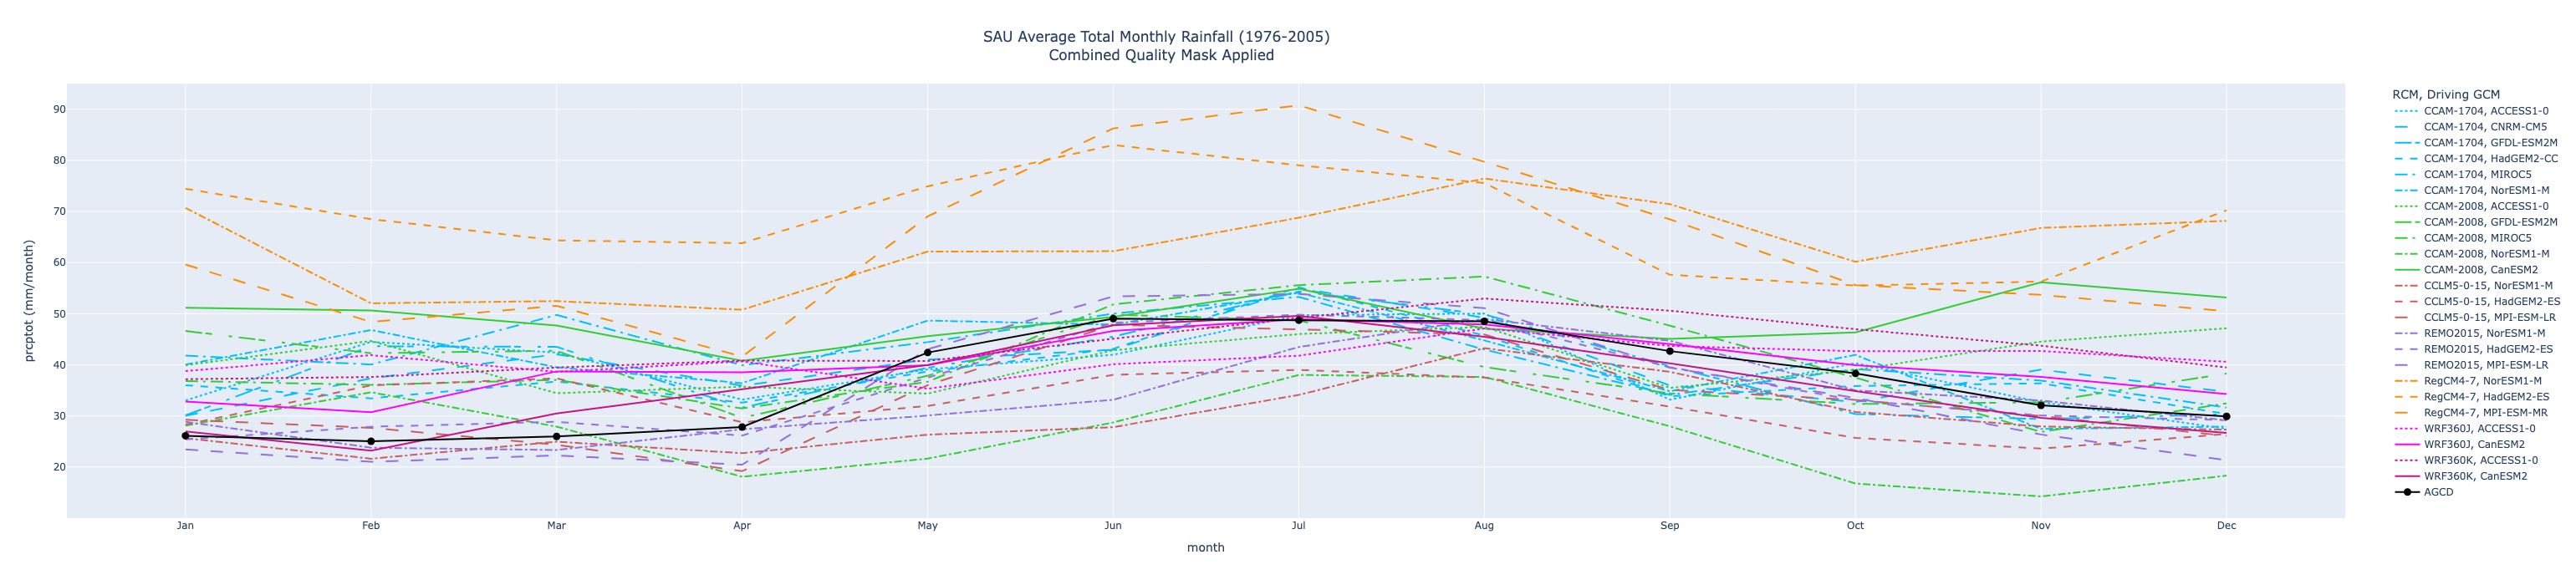

In [16]:
# Define line styles based on GCM and colors based on RCM
gcm_lines = {'NorESM1-M':'dashdot',
             'CNRM-CM5':'longdash',
             'CanESM2':'solid',
             'ACCESS1-0':'dot',
             'HadGEM2-ES':'dash',
             'MPI-ESM-LR':'longdash',
             'HadGEM2-CC':'dash',
             'GFDL-ESM2M':'20px,4px,8px',
             'MIROC5':'longdashdot',
             'MPI-ESM-MR':'longdash'
             }

rcm_colors = {'CCAM-1704':'deepskyblue',
             'CCAM-2008':'limegreen',
             'WRF360J':'magenta',
             'WRF360K':'mediumvioletred',
             'CCLM5-0-15':'indianred',
             'REMO2015':'mediumpurple',
             'RegCM4-7':'darkorange'}


ts_fig = px.line(rcm_master_timeseries_df, x=rcm_master_timeseries_df['month'], y=f"{variable}", line_dash='driving_gcm', line_dash_map=gcm_lines, color='rcm', color_discrete_map=rcm_colors,
                 hover_data=['rcm', 'driving_gcm', f"{variable}"], width=1080, height=700,
    labels={
         "rcm": "RCM",
         "driving_gcm": "Driving GCM",
         f"{variable}": f"{variable}" " (mm/month)",
         "index": "Month",
     },
    title= "SAU Average Total Monthly Rainfall (1976-2005) <br> Combined Quality Mask Applied")

ts_fig.update_traces(marker={'size': 8})

# Add Observations 
ts_fig.add_trace(go.Scatter(
    x=agcd_monthly_avg_df['month'], y=agcd_monthly_avg_df[f"{variable}"],
    line_color='rgb(0,0,0)',
    name='AGCD',
    hovertemplate = 'AGCD: %{y:.2f}mm<br>Month: %{x}<extra></extra>',
    marker={'size': 9}

))

ts_fig.update_layout(title_x=0.45)

ts_fig.show()